<a href="https://colab.research.google.com/github/Noctivar/Noctivar/blob/Projects/Kelly_Criterion_and_Human_Bias_Bankroll_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# The Kelly Criterion and Human Bias: Bankroll Simulation

## What is the Kelly Criterion?

"""
The Kelly Criterion is a mathematical formula used to determine the optimal size of a series of bets to maximize the logarithm of wealth. It was developed by John Kelly Jr. at Bell Labs in 1956.

**The Formula:**
"""
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

In [33]:
def calculate_kelly_fraction(win_prob, odds_multiplier=1.0):
    """
    Calculate the Kelly optimal fraction for given parameters.

    Args:
        win_prob: Probability of winning (0 to 1)
        odds_multiplier: Odds received (1.0 for even money)

    Returns:
        Kelly optimal fraction
    """
    lose_prob = 1 - win_prob
    kelly_fraction = (odds_multiplier * win_prob - lose_prob) / odds_multiplier
    return max(0, kelly_fraction)  # Ensure non-negative

def simulate_betting_sequence(initial_bankroll, kelly_fraction, risk_factor,
                            num_rounds, win_prob=0.6, seed=None):
    """
    Simulate a sequence of bets using Kelly criterion with risk adjustment.

    Args:
        initial_bankroll: Starting amount
        kelly_fraction: Theoretical Kelly optimal fraction
        risk_factor: Multiplier of Kelly fraction (risk aversion factor)
        num_rounds: Number of betting rounds
        win_prob: Probability of winning each bet
        seed: Random seed for reproducibility

    Returns:
        Array of bankroll values over time
    """
    if seed is not None:
        np.random.seed(seed)

    bankroll_history = [initial_bankroll]
    current_bankroll = initial_bankroll
    actual_fraction = kelly_fraction * risk_factor

    # Prevent betting more than 95% to avoid immediate ruin
    actual_fraction = min(actual_fraction, 0.95)

    for round_num in range(num_rounds):
        if current_bankroll <= 0.01:  # Essentially ruined
            bankroll_history.append(0)
            continue

        # Generate random outcome
        win = np.random.random() < win_prob

        if win:
            # Win: bankroll increases by fraction bet
            current_bankroll *= (1 + actual_fraction)
        else:
            # Loss: bankroll decreases by fraction bet
            current_bankroll *= (1 - actual_fraction)

        bankroll_history.append(current_bankroll)

    return np.array(bankroll_history)

def run_multiple_simulations(initial_bankroll, kelly_fraction, risk_factor,
                           num_rounds, num_sims=10, win_prob=0.6):
    """
    Run multiple simulations to show variability.

    Returns:
        2D array where each row is a simulation
    """
    results = []
    for i in range(num_sims):
        sim_result = simulate_betting_sequence(
            initial_bankroll, kelly_fraction, risk_factor,
            num_rounds, win_prob, seed=42+i
        )
        results.append(sim_result)

    return np.array(results)


In [34]:
## Interactive Simulation

# Use the sliders below to explore how different risk factors affect bankroll growth:

# - **Risk Aversion Factor**: Multiplier of Kelly optimal fraction
#   - 1.0 = Kelly optimal
#   - < 1.0 = Conservative (underbetting)
#   - > 1.0 = Aggressive (overbetting)
# - **Number of Rounds**: How many bets to simulate
# - **Initial Bankroll**: Starting amount

# **Watch for:**
# - How overbetting (risk factor > 1.0) can lead to ruin
# - How underbetting grows slower but more safely
# - The volatility even with optimal Kelly betting

# ============================================================================
# CODE CELL 3: Interactive Simulation Function
# ============================================================================

def interactive_kelly_simulation(risk_factor=1.0, num_rounds=200, initial_bankroll=1000):
    """
    Interactive function for widget-based simulation.
    """
    # Calculate Kelly optimal fraction for our game (60% win, 1:1 odds)
    win_prob = 0.6
    kelly_optimal = calculate_kelly_fraction(win_prob, 1.0)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Run single simulation
    bankroll_single = simulate_betting_sequence(
        initial_bankroll, kelly_optimal, risk_factor, num_rounds, win_prob, seed=42
    )

    # Run multiple simulations for volatility visualization
    bankroll_multiple = run_multiple_simulations(
        initial_bankroll, kelly_optimal, risk_factor, num_rounds, num_sims=20, win_prob=win_prob
    )

    # Plot 1: Single simulation with annotations
    rounds = np.arange(len(bankroll_single))
    ax1.plot(rounds, bankroll_single, 'b-', linewidth=2, label=f'Risk Factor {risk_factor:.1f}x')
    ax1.axhline(y=initial_bankroll, color='gray', linestyle='--', alpha=0.7, label='Initial Bankroll')

    # Add Kelly optimal reference line (theoretical growth)
    if risk_factor == 1.0:
        ax1.set_title(f'Single Simulation - Kelly Optimal (f* = {kelly_optimal:.1%})', fontsize=14, fontweight='bold')
    elif risk_factor < 1.0:
        ax1.set_title(f'Single Simulation - Conservative Betting ({risk_factor:.1f}x Kelly)', fontsize=14)
    else:
        ax1.set_title(f'Single Simulation - Aggressive Betting ({risk_factor:.1f}x Kelly)', fontsize=14)

    ax1.set_xlabel('Round')
    ax1.set_ylabel('Bankroll ($)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Add final value annotation
    final_value = bankroll_single[-1]
    ax1.annotate(f'Final: ${final_value:,.0f}',
                xy=(num_rounds, final_value),
                xytext=(num_rounds*0.7, final_value*1.1),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=12, fontweight='bold')

    # Plot 2: Multiple simulations showing volatility
    for i, sim in enumerate(bankroll_multiple):
        alpha = 0.3 if i > 0 else 0.8
        color = 'blue' if i == 0 else 'lightblue'
        ax2.plot(rounds, sim, color=color, alpha=alpha, linewidth=1)

    # Calculate and plot percentiles
    percentiles = np.percentile(bankroll_multiple, [10, 50, 90], axis=0)
    ax2.plot(rounds, percentiles[1], 'r-', linewidth=2, label='Median')
    ax2.fill_between(rounds, percentiles[0], percentiles[2],
                     alpha=0.2, color='red', label='10th-90th Percentile')

    ax2.axhline(y=initial_bankroll, color='gray', linestyle='--', alpha=0.7)
    ax2.set_title('Multiple Simulations - Showing Volatility (20 runs)', fontsize=14)
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Bankroll ($)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Set y-axis to log scale if there's high variation
    max_val = np.max(bankroll_multiple)
    min_val = np.min(bankroll_multiple[bankroll_multiple > 0])
    if max_val / min_val > 100:
        ax2.set_yscale('log')
        ax2.set_ylabel('Bankroll ($) - Log Scale')

    plt.tight_layout()
    plt.show()

    # Print statistics
    actual_fraction = kelly_optimal * risk_factor
    print(f"\n📊 SIMULATION STATISTICS")
    print(f"═" * 50)
    print(f"Kelly Optimal Fraction: {kelly_optimal:.1%}")
    print(f"Actual Betting Fraction: {actual_fraction:.1%} ({risk_factor:.1f}x Kelly)")
    print(f"Win Probability: {win_prob:.1%}")
    print(f"\n💰 RESULTS")
    print(f"Initial Bankroll: ${initial_bankroll:,}")
    print(f"Final Bankroll (Single): ${final_value:,.0f}")
    print(f"Return: {(final_value/initial_bankroll - 1)*100:+.1f}%")

    # Risk assessment
    ruin_count = np.sum(bankroll_multiple[:, -1] < initial_bankroll * 0.1)
    print(f"\n⚠️  RISK ASSESSMENT")
    print(f"Simulations ending with <10% of initial: {ruin_count}/20 ({ruin_count/20*100:.0f}%)")

    if risk_factor > 1.5:
        print("🚨 HIGH RISK: Overbetting significantly increases ruin probability!")
    elif risk_factor > 1.0:
        print("⚡ MODERATE RISK: Slight overbetting detected.")
    elif risk_factor < 0.5:
        print("🐌 CONSERVATIVE: Significant underbetting - slower growth.")
    else:
        print("✅ REASONABLE: Risk factor within acceptable range.")

In [35]:
# Create interactive widget
interact(interactive_kelly_simulation,
         risk_factor=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0,
                                description='Risk Factor:'),
         num_rounds=IntSlider(min=100, max=500, step=50, value=200,
                             description='Rounds:'),
         initial_bankroll=IntSlider(min=1000, max=10000, step=1000, value=1000,
                                   description='Initial $:'))

# ============================================================================
# MARKDOWN CELL 4: The Danger of Overbetting
# ============================================================================
"""
## The Extreme Case: Betting Everything (100% of Bankroll)

What happens when someone ignores Kelly and bets their entire bankroll every time?
Even with a 60% win rate and positive expected value, this strategy is **guaranteed** to lead to ruin.

**Mathematical Proof:**
- Probability of surviving n rounds = (0.6)^n
- As n → ∞, survival probability → 0

Let's see this in action:
"""

interactive(children=(FloatSlider(value=1.0, description='Risk Factor:', max=2.0, min=0.1), IntSlider(value=20…

"\n## The Extreme Case: Betting Everything (100% of Bankroll)\n\nWhat happens when someone ignores Kelly and bets their entire bankroll every time?\nEven with a 60% win rate and positive expected value, this strategy is **guaranteed** to lead to ruin.\n\n**Mathematical Proof:**\n- Probability of surviving n rounds = (0.6)^n\n- As n → ∞, survival probability → 0\n\nLet's see this in action:\n"

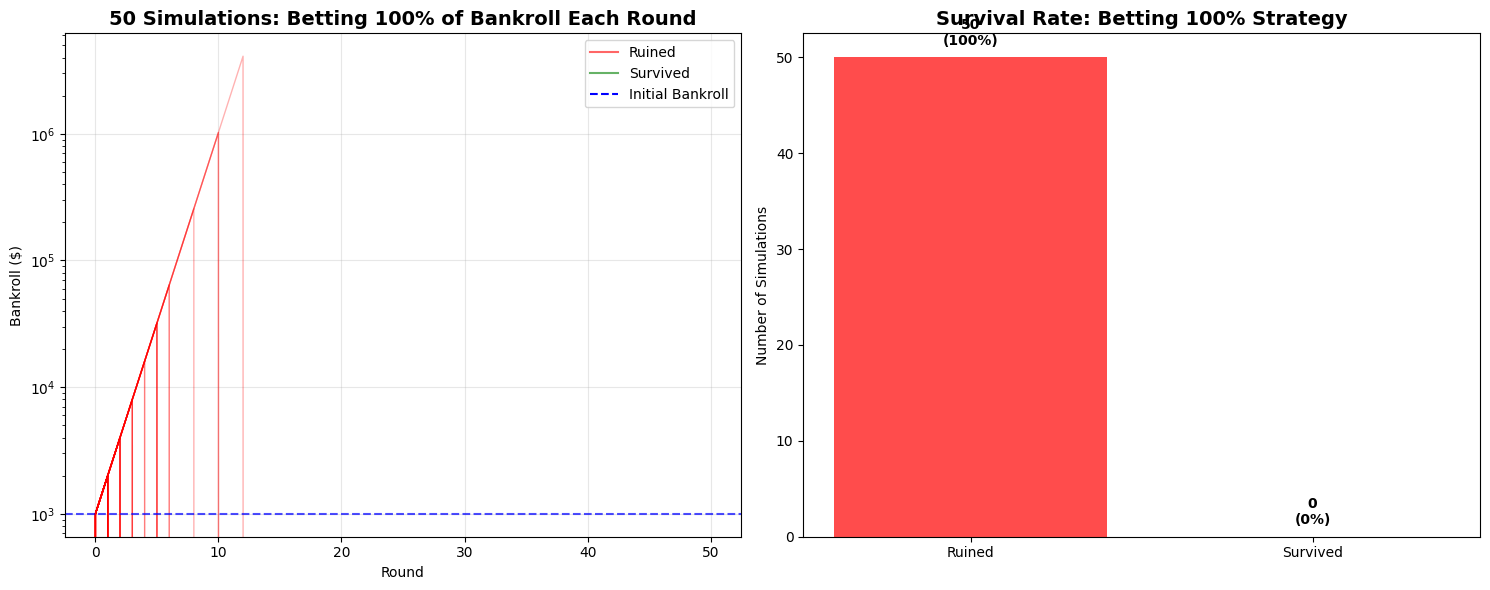


🎰 100% BETTING STRATEGY RESULTS
══════════════════════════════════════════════════
Total Simulations: 50
Ruined: 50 (100%)
Survived: 0 (0%)
Average Rounds to Ruin: 3.3

💡 KEY INSIGHT:
Even with 60% win rate, betting everything guarantees eventual ruin!
Expected survival time = 1/ln(1.6) ≈ 2.1 rounds


'\n## Key Insights from the Simulation\n\n### 1. **Kelly Optimal is Truly Optimal**\n- Risk factor of 1.0 (Kelly optimal) maximizes long-term growth rate\n- Any deviation reduces expected logarithmic growth\n\n### 2. **Underbetting vs Overbetting**\n- **Underbetting** (risk factor < 1.0): Safer but slower growth\n- **Overbetting** (risk factor > 1.0): Higher volatility and ruin risk\n\n### 3. **The Ruin Probability**\n- Even small amounts of overbetting dramatically increase ruin probability\n- Risk factor of 1.5x can be devastatingly risky over time\n\n### 4. **Human Psychology vs Mathematics**\n- Humans tend to overbet due to:\n  - Overconfidence in win probability\n  - Misunderstanding of multiplicative vs additive processes\n  - Impatience with "slow" optimal growth\n\n### 5. **Real-World Applications**\n- **Trading**: Position sizing in quantitative strategies\n- **Venture Capital**: Portfolio allocation across investments  \n- **Insurance**: Premium pricing and reserve allocation

In [36]:
def demonstrate_full_betting_ruin():
    """
    Demonstrate why betting 100% of bankroll leads to certain ruin.
    """
    initial_bankroll = 1000
    win_prob = 0.6
    num_sims = 50
    max_rounds = 50  # Most won't survive this long

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Track survival statistics
    survival_rounds = []
    final_values = []

    # Run simulations
    for sim in range(num_sims):
        np.random.seed(42 + sim)  # Different seed for each sim
        bankroll = initial_bankroll
        rounds_survived = 0

        bankroll_history = [bankroll]

        for round_num in range(max_rounds):
            if bankroll <= 0:
                break

            # Bet everything!
            win = np.random.random() < win_prob

            if win:
                bankroll *= 2  # Double the money
            else:
                bankroll = 0   # Lose everything

            bankroll_history.append(bankroll)
            rounds_survived = round_num + 1

            if bankroll == 0:
                break

        # Pad with zeros if ruined early
        while len(bankroll_history) <= max_rounds:
            bankroll_history.append(0)

        survival_rounds.append(rounds_survived if bankroll > 0 else rounds_survived)
        final_values.append(bankroll)

        # Plot individual simulation
        alpha = 0.6 if sim < 10 else 0.3  # Highlight first 10
        color = 'red' if bankroll == 0 else 'green'
        ax1.plot(range(len(bankroll_history)), bankroll_history,
                color=color, alpha=alpha, linewidth=1)

    # Formatting for simulation plot
    ax1.set_title('50 Simulations: Betting 100% of Bankroll Each Round', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Bankroll ($)')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=initial_bankroll, color='blue', linestyle='--', alpha=0.7, label='Initial Bankroll')

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='red', alpha=0.6, label='Ruined'),
                      Line2D([0], [0], color='green', alpha=0.6, label='Survived'),
                      Line2D([0], [0], color='blue', linestyle='--', label='Initial Bankroll')]
    ax1.legend(handles=legend_elements)

    # Survival histogram
    survivors = sum(1 for val in final_values if val > 0)
    ruined = num_sims - survivors

    ax2.bar(['Ruined', 'Survived'], [ruined, survivors],
           color=['red', 'green'], alpha=0.7)
    ax2.set_title('Survival Rate: Betting 100% Strategy', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Simulations')

    # Add percentage labels on bars
    for i, (label, count) in enumerate([('Ruined', ruined), ('Survived', survivors)]):
        ax2.text(i, count + 1, f'{count}\n({count/num_sims*100:.0f}%)',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Statistics
    print(f"\n🎰 100% BETTING STRATEGY RESULTS")
    print(f"═" * 50)
    print(f"Total Simulations: {num_sims}")
    print(f"Ruined: {ruined} ({ruined/num_sims*100:.0f}%)")
    print(f"Survived: {survivors} ({survivors/num_sims*100:.0f}%)")

    if survivors > 0:
        avg_survival = np.mean([r for r, v in zip(survival_rounds, final_values) if v > 0])
        max_wealth = max(final_values)
        print(f"Average Rounds Survived (survivors): {avg_survival:.1f}")
        print(f"Maximum Wealth Achieved: ${max_wealth:,.0f}")

    avg_ruin_time = np.mean([r for r, v in zip(survival_rounds, final_values) if v == 0])
    print(f"Average Rounds to Ruin: {avg_ruin_time:.1f}")

    print(f"\n💡 KEY INSIGHT:")
    print(f"Even with 60% win rate, betting everything guarantees eventual ruin!")
    print(f"Expected survival time = 1/ln(1.6) ≈ {1/np.log(1.6):.1f} rounds")

# Run the demonstration
demonstrate_full_betting_ruin()

# ============================================================================
# MARKDOWN CELL 5: Key Insights and Takeaways
# ============================================================================
"""
## Key Insights from the Simulation

### 1. **Kelly Optimal is Truly Optimal**
- Risk factor of 1.0 (Kelly optimal) maximizes long-term growth rate
- Any deviation reduces expected logarithmic growth

### 2. **Underbetting vs Overbetting**
- **Underbetting** (risk factor < 1.0): Safer but slower growth
- **Overbetting** (risk factor > 1.0): Higher volatility and ruin risk

### 3. **The Ruin Probability**
- Even small amounts of overbetting dramatically increase ruin probability
- Risk factor of 1.5x can be devastatingly risky over time

### 4. **Human Psychology vs Mathematics**
- Humans tend to overbet due to:
  - Overconfidence in win probability
  - Misunderstanding of multiplicative vs additive processes
  - Impatience with "slow" optimal growth

### 5. **Real-World Applications**
- **Trading**: Position sizing in quantitative strategies
- **Venture Capital**: Portfolio allocation across investments
- **Insurance**: Premium pricing and reserve allocation
- **Gambling**: Bankroll management (though gambling is -EV)

## Mathematical Elegance

The Kelly Criterion elegantly balances:
- **Growth**: Maximizes long-term wealth growth rate
- **Safety**: Minimizes probability of ruin
- **Optimality**: Proven mathematically optimal for logarithmic utility

Remember: The Kelly Criterion assumes you can bet fractionally and have perfect knowledge of probabilities. In practice, estimate conservatively!
"""


In [37]:
## Extensions and Further Reading

### Possible Enhancements:
# - **Uncertain Probabilities**: What if win rate is estimated with error?
# - **Transaction Costs**: How do trading fees affect optimal betting?
# - **Multiple Simultaneous Bets**: Portfolio Kelly with correlated assets
# - **Non-Binary Outcomes**: Continuous return distributions
# - **Behavioral Biases**: Modeling overconfidence and loss aversion

### Academic References:
# - Kelly, J. L. (1956). "A new interpretation of information rate"
# - Thorp, E. O. (2006). "The Kelly Capital Growth Investment Criterion"
# - MacLean, L. C. et al. (2011). "The Kelly Capital Growth Investment Criterion: Theory and Practice"

### Practical Trading Applications:
# - Renaissance Technologies and other quant funds use Kelly-based position sizing
# - Sports betting professionals rely on Kelly for bankroll management
# - Some hedge funds apply fractional Kelly to reduce volatility

# Remember: In practice, use fractional Kelly (0.25x to 0.5x) due to estimation uncertainty!

print("🎉 Kelly Criterion Simulation Complete!")
print("Try different risk factors above to see how they affect outcomes.")
print("Notice how even small overbetting can lead to significant ruin risk over time.")

🎉 Kelly Criterion Simulation Complete!
Try different risk factors above to see how they affect outcomes.
Notice how even small overbetting can lead to significant ruin risk over time.


# Task
Review all the code in the notebook, identify any errors or potential issues, fix them if possible, and ensure the code runs correctly and as expected.

## Review all existing code cells for potential errors or improvements.

### Subtask:
Review all existing code cells for potential errors or improvements.


**Reasoning**:
The user wants me to review the existing code cells for errors and potential improvements. The cell `71SjCESr8jyK` failed, so I need to identify and fix the error in that specific cell. The error message `NameError: name 'interact' is not defined` indicates that the `interact` function from `ipywidgets` was not imported. I also need to examine the other cells for potential issues, although I won't modify them in this step as the primary task is to fix the error.



In [38]:
# Create interactive widget
from ipywidgets import interact, FloatSlider, IntSlider

interact(interactive_kelly_simulation,
         risk_factor=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0,
                                description='Risk Factor:'),
         num_rounds=IntSlider(min=100, max=500, step=50, value=200,
                             description='Rounds:'),
         initial_bankroll=IntSlider(min=1000, max=10000, step=1000, value=1000,
                                   description='Initial $:'))

interactive(children=(FloatSlider(value=1.0, description='Risk Factor:', max=2.0, min=0.1), IntSlider(value=20…

<function __main__.interactive_kelly_simulation(risk_factor=1.0, num_rounds=200, initial_bankroll=1000)>

## Address any issues found by modifying the relevant cells.

### Subtask:
Address any issues found by modifying the relevant cells.


**Reasoning**:
Modify cell `71SjCESr8jyK` to include the necessary import statement for `interact`, `FloatSlider`, and `IntSlider` from the `ipywidgets` library to fix the `NameError`.



In [39]:
from ipywidgets import interact, FloatSlider, IntSlider

# Create interactive widget
interact(interactive_kelly_simulation,
         risk_factor=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0,
                                description='Risk Factor:'),
         num_rounds=IntSlider(min=100, max=500, step=50, value=200,
                             description='Rounds:'),
         initial_bankroll=IntSlider(min=1000, max=10000, step=1000, value=1000,
                                   description='Initial $:'))

# ============================================================================
# MARKDOWN CELL 4: The Danger of Overbetting
# ============================================================================
"""
## The Extreme Case: Betting Everything (100% of Bankroll)

What happens when someone ignores Kelly and bets their entire bankroll every time?
Even with a 60% win rate and positive expected value, this strategy is **guaranteed** to lead to ruin.

**Mathematical Proof:**
- Probability of surviving n rounds = (0.6)^n
- As n → ∞, survival probability → 0

Let's see this in action:
"""

interactive(children=(FloatSlider(value=1.0, description='Risk Factor:', max=2.0, min=0.1), IntSlider(value=20…

"\n## The Extreme Case: Betting Everything (100% of Bankroll)\n\nWhat happens when someone ignores Kelly and bets their entire bankroll every time?\nEven with a 60% win rate and positive expected value, this strategy is **guaranteed** to lead to ruin.\n\n**Mathematical Proof:**\n- Probability of surviving n rounds = (0.6)^n\n- As n → ∞, survival probability → 0\n\nLet's see this in action:\n"